In [1]:
%matplotlib inline

In [2]:
from importlib import reload

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Force layout

Given the results from the [previous notebook](experiment_0.ipynb), where force layout algorithms had trouble embedding MNIST-70k, which is a prototypical dataset for t-sne, I decided to look into a small

Here, we re-implement the force layout alogorithm to explore the type of layout produced with a knowingly correct implementation.

The expression for the stress to optimise is: $stress(X) = \sum_{i<j}w_{ij}(||X_i - X_j|| - d_{ij})^2$ with $w_{ij} = d_{ij}^{-2}$, $||X_i - X_j||$ the euclidean norm computed in the low-dimensional embedding and $d_{ij}$ representing the pairwise distance in the high-dimensional embedding.

The gradient for this cost has an analytical solution equal to:

$grad_i(stress(X_i)) = \sum_j 4 w_{ij} \frac{(X_i - X_j)}{||X_i - X_j||} (||X_i - X_j|| - d_{ij})$

Replacing $(X_i - X_j)$ with `ld_ij_2`, $||X_i - X_j||$ with `ld_ij_1` and $d_{ij}$ with `hd_ij`, we have:

`grad_i(stress(X_i)) = \sum_j 4 ld_ij_1 / hd_ij_2  * (ld_ij_2 - hd_ij) / hd_ij^2`

This expression can be computed in different ways. An explicit way does implement the computation for the gradient of the stress:

```python
def force(emb, hd_ij, inv_hd_ij_2):
    """Compute the gradient of a given embedding, given the high dimensional pairwise distances.
    hd_ij, ld_ij: pairwise distances in high, low dimensional space resp.
    """
    pdist = ss.distance.pdist(emb, 'euclidean')
    ld_ij_2 = ss.distance.squareform(pdist)

    F_ij_2 = (ld_ij_2 - hd_ij) / (ld_ij_2 + EPSILON)
    F_ij = F_ij_2[:,:] * inv_hd_ij_2

    a = pos[:, None, :]
    ld_ij_1 = (a - a.swapaxes(0,1))

    F_ij = F_ij[:,:,None] * ld_ij_1

    F_i = np.sum(F_ij, axis=1)

    return 4*F_i
```

It is also possible to use autograd to compute the gradient of a given cost:


```python
def stress(X):
    X = X[:, None, :]
    ld_ij_2 = np.sqrt(np.sum(((X - X.swapaxes(0,1))**2), axis=2) + EPSILON)
    res = np.sum((ld_ij_2 - hd_ij)**2 * inv_hd_ij_2)
    return res

gradient = grad(stress)
```

Similar to a N-body simulation, an optimisation can take place in which the gradient descent is used.

```python
def gd(grad, x, callback=None, num_iters=200):
    for i in range(num_iters):
        g = grad()
        x -= g/2  # if full gradient, optimisation is unstable
    return x

def sgd(grad, x, num_iters=200, step_size=0.1, mass=0.9):
    velocity = np.zeros(x.shape)
    for i in range(num_iters):
        g = grad()
        velocity = mass * velocity - (1.0 - mass) * g
        x += step_size * velocity
    return x
```

# MNIST-2k

In [2]:
import tools

In [5]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [3]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-2k')

In [7]:
import pyforce

In [8]:
pdist = pyforce.Distances(X_train)

In [9]:
pca = PCA(n_components=2).fit_transform(X_train)
pca = preprocessing.scale(pca)

In [10]:
fe_pca = pyforce.ForceEmbedding(pca.copy(), pdist)

In [22]:
%time _= fe_pca.optimize(n_iter=100)

CPU times: user 1min 38s, sys: 4.06 s, total: 1min 42s
Wall time: 26.2 s


In [12]:
fe_pca_sgd = pyforce.ForceEmbedding(pca.copy(), pdist)

In [13]:
%time _= fe_pca_sgd.optimize(n_iter=100, method='sgd')

CPU times: user 1min 38s, sys: 4.14 s, total: 1min 42s
Wall time: 26.8 s


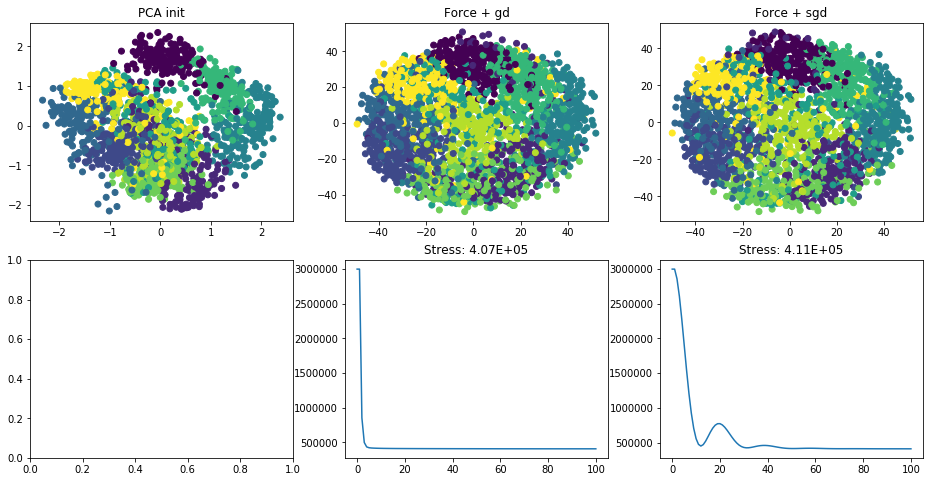

In [21]:
fig, ax = plt.subplots(2,3, figsize=(16,8))

ax[0,0].scatter(pca[:,0], pca[:,1], c=y_train)
_=ax[0,0].set_title("PCA init")

ax[0,1].scatter(fe_pca[:,0], fe_pca[:,1], c=y_train)
_=ax[0,1].set_title("Force + gd")
ax[1,1].plot(np.array(fe_pca.error))
_=ax[1,1].set_title("Stress: {:.2E}".format(fe_pca.stress()))

ax[0,2].scatter(fe_pca_sgd[:,0], fe_pca_sgd[:,1], c=y_train)
_=ax[0,2].set_title("Force + sgd")
ax[1,2].plot(np.array(fe_pca_sgd.error))
_=ax[1,2].set_title("Stress: {:.2E}".format(fe_pca_sgd.stress()))

# MNIST-70K root N

The result above is not as sharp as t-sne, but potentially could be used as an initialisation for it.

Here we change to MNIST-70k, and test a Root N init.

In [23]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-70k')

## sample 2000

In [30]:
N = 2000 #X_train.shape[0]
rootN = np.int(np.sqrt(N))
rootN = N
rootN_ids = np.random.choice(N, size=rootN, replace=False)
rootN_data = X_train[rootN_ids]

In [31]:
pca = PCA(n_components=2).fit_transform(rootN_data)
pca = preprocessing.scale(pca)

In [32]:
pdist = pyforce.Distances(rootN_data)

In [33]:
fe_rootN = pyforce.ForceEmbedding(pca.copy(), pdist)

In [34]:
%time _=fe_rootN.optimize(n_iter=1000, method='sgd')

CPU times: user 1min 48s, sys: 4.54 s, total: 1min 52s
Wall time: 32.8 s


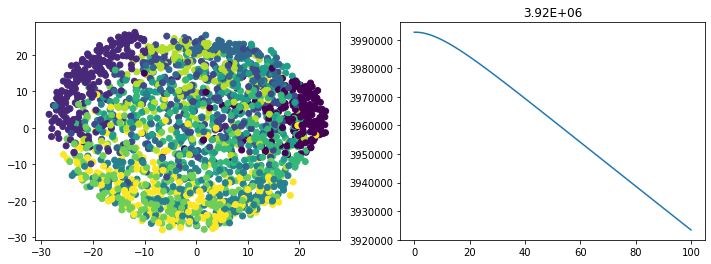

In [35]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(fe_rootN[:,0], fe_rootN[:,1], c=y_train[rootN_ids])
ax[1].plot(np.array(fe_rootN.error))
_=ax[1].set_title("{:.2E}".format(fe_rootN.stress()))
